## 2nd Project | Trading

###  Instructions
- Follow a Python Project structure.
- Work with a training and validation dataset to optimize & test your trading strategies using the datasets provided in the introduction section.
- Select n technical indicators (one for each team member).
- For each timeframe train/test files (1d, 1h, 5m, 1m):
    - Define buy/sell signals for each indicator.
    - Create all possible combinations of all technical indicators (2^n - 1).
    - Backtest the strategies while keeping track of the operations and cash/portfolio value time series, remember that we'll be opening long & short positions.
    - Optimize all technical indicator's parameters (TPE, Grid Search, PSO, Genetic Algorithms, ...), stop-loss/take-profit, volume of the trade, maximizing the profit of the strategy with the training dataset, consider the bounds of each variable!
    - Select the optimal strategy and describe it thoroughly (what indicators are used, when is the trade signal produced, etc.).
    - Now, use the optimal strategy with the test dataset and compare it to a passive strategy.


-------

In [1]:
from technical_analysis import Operation, TradingStrategy

show example of available all indicators

In [2]:
strategy = TradingStrategy('5m')

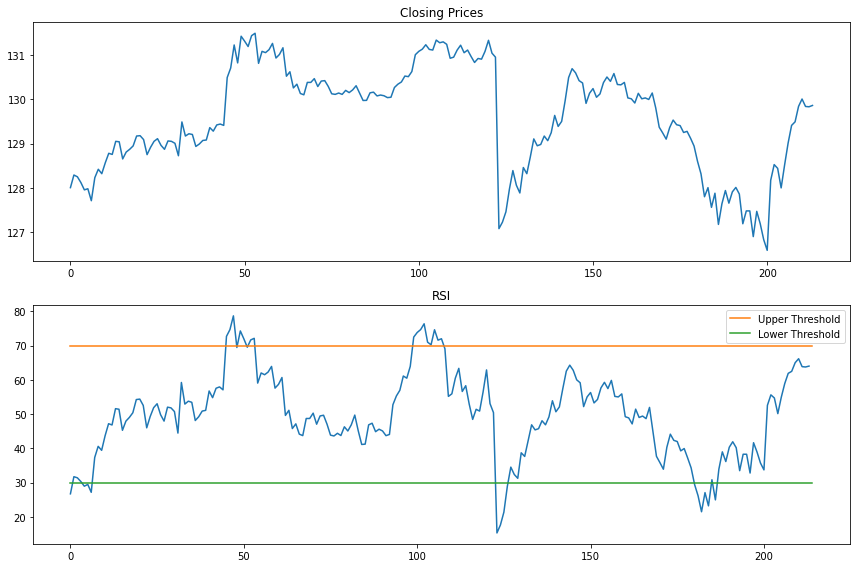

In [3]:
strategy.show_RSI()

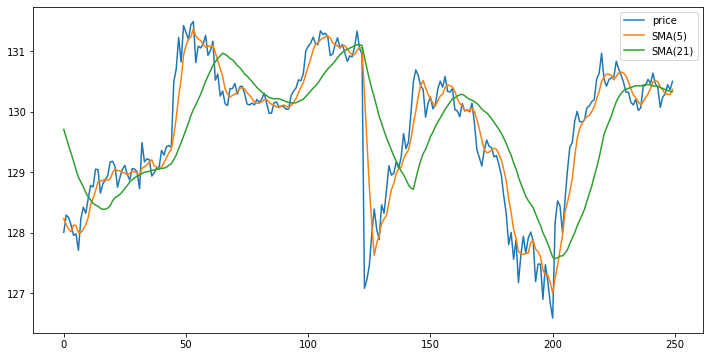

In [4]:
strategy.show_SMAs()

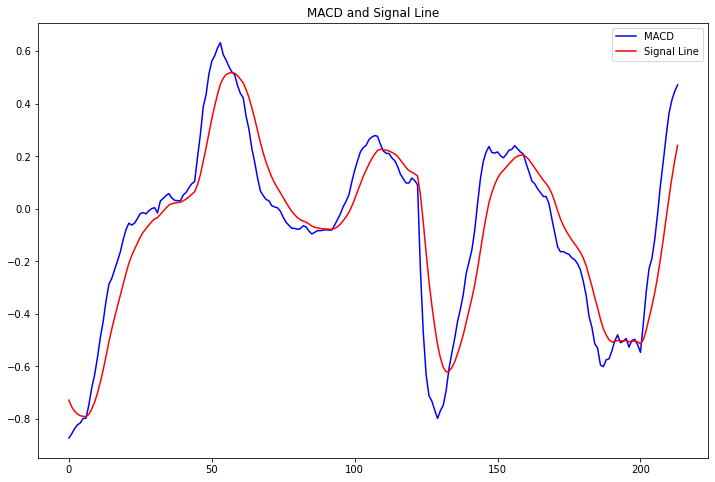

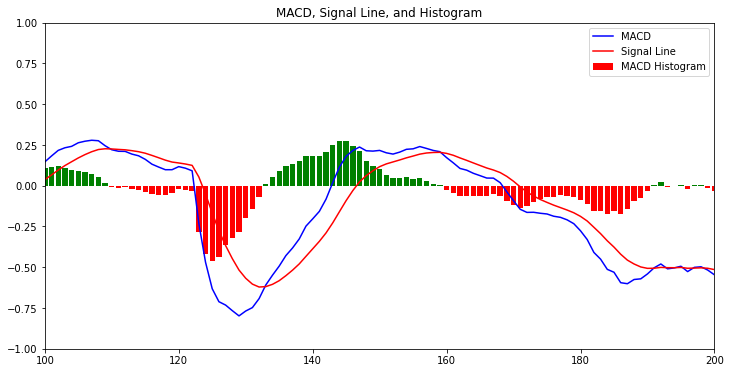

In [5]:
strategy.show_MACD()

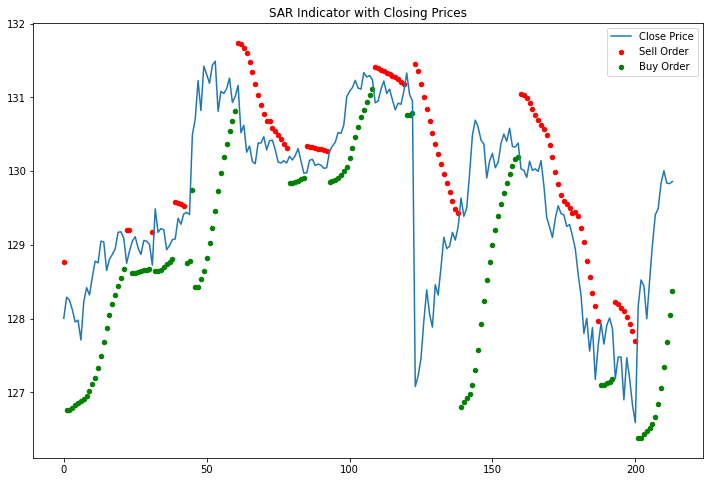

In [6]:
strategy.show_SAR()

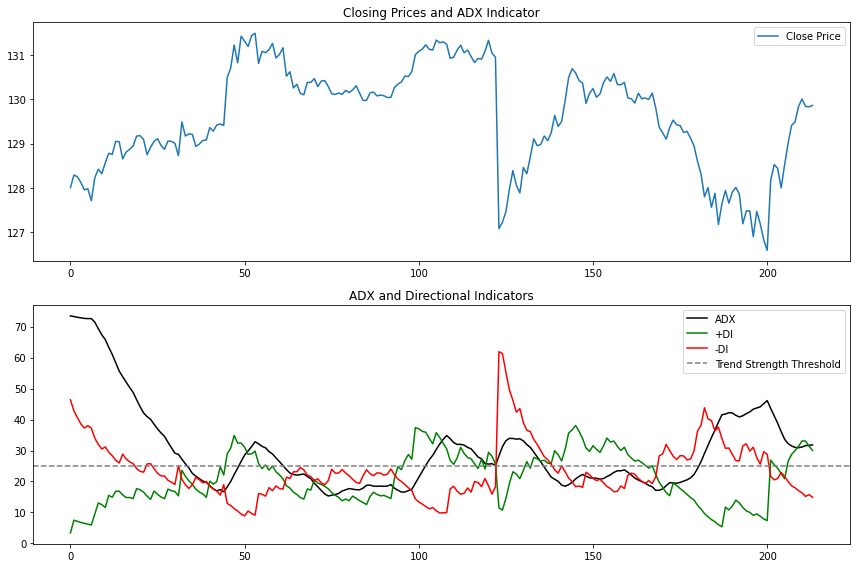

In [7]:
strategy.show_ADX_strat()

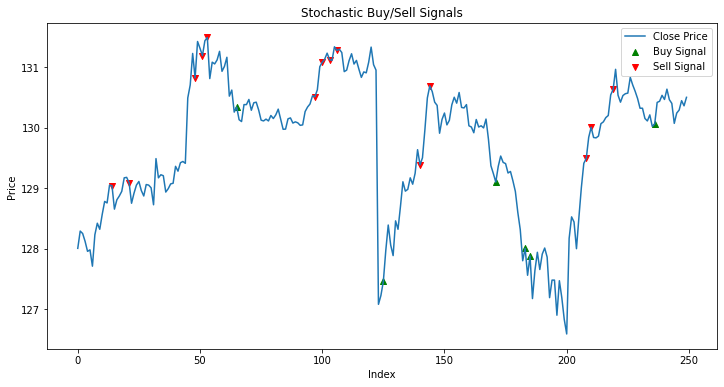

In [8]:
strategy.plot_stochastic_signals()

get best combination (model)

In [10]:
strategy.run_combinations()

Ejecutando con combinación de indicadores: ['RSI']
Ejecutando con combinación de indicadores: ['SMA']
Ejecutando con combinación de indicadores: ['MACD']
Ejecutando con combinación de indicadores: ['SAR']
Ejecutando con combinación de indicadores: ['ADX']
Ejecutando con combinación de indicadores: ['Stoch']
Ejecutando con combinación de indicadores: ['RSI', 'SMA']
Ejecutando con combinación de indicadores: ['RSI', 'MACD']
Ejecutando con combinación de indicadores: ['RSI', 'SAR']
Ejecutando con combinación de indicadores: ['RSI', 'ADX']
Ejecutando con combinación de indicadores: ['RSI', 'Stoch']
Ejecutando con combinación de indicadores: ['SMA', 'MACD']
Ejecutando con combinación de indicadores: ['SMA', 'SAR']
Ejecutando con combinación de indicadores: ['SMA', 'ADX']
Ejecutando con combinación de indicadores: ['SMA', 'Stoch']
Ejecutando con combinación de indicadores: ['MACD', 'SAR']
Ejecutando con combinación de indicadores: ['MACD', 'ADX']
Ejecutando con combinación de indicadores: ['

show best model backtesting

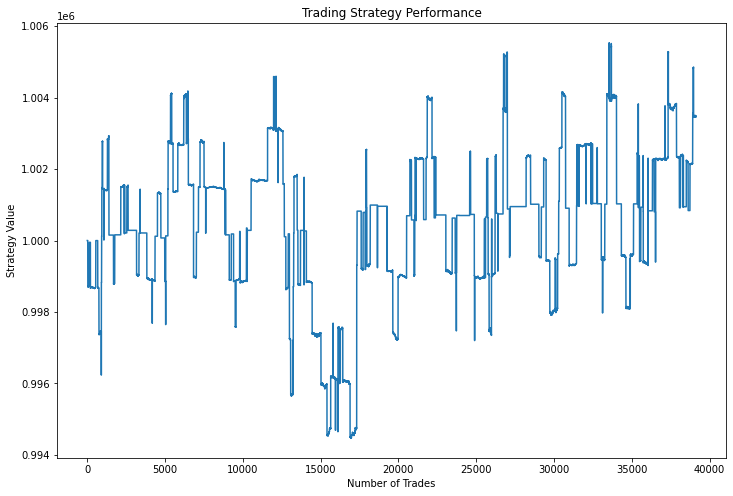

In [11]:
strategy.plot_best_results()

best model without optimization on test

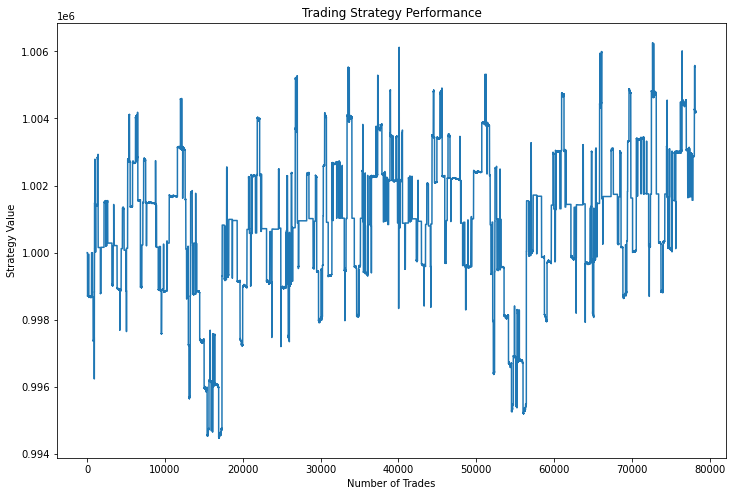

In [12]:
strategy.test()

In [13]:
strategy.strategy_value[-1]

1004180.2180573121

optimize parameters

In [14]:
strategy.optimize_parameters()

[I 2024-02-23 19:25:27,337] A new study created in memory with name: no-name-00b057a6-531a-4d96-a96f-ad10536f8a63
[I 2024-02-23 19:26:11,562] Trial 0 finished with value: 999252.0574870126 and parameters: {'sar_step': 0.09627202134753172, 'sar_max_step': 0.19654492658653677, 'adx_window': 29}. Best is trial 0 with value: 999252.0574870126.
[I 2024-02-23 19:26:56,845] Trial 1 finished with value: 1000216.2791794749 and parameters: {'sar_step': 0.07994158130317522, 'sar_max_step': 0.2595598872909676, 'adx_window': 25}. Best is trial 1 with value: 1000216.2791794749.
[I 2024-02-23 19:27:42,269] Trial 2 finished with value: 1000132.6193668373 and parameters: {'sar_step': 0.07799225690873261, 'sar_max_step': 0.26480454000407105, 'adx_window': 11}. Best is trial 1 with value: 1000216.2791794749.
[I 2024-02-23 19:28:25,121] Trial 3 finished with value: 999278.4053711377 and parameters: {'sar_step': 0.06940585211015338, 'sar_max_step': 0.20153226369160443, 'adx_window': 29}. Best is trial 1 wi

Mejores parámetros encontrados: {'sar_step': 0.01037570113940818, 'sar_max_step': 0.1767902948212112, 'adx_window': 13}


show strategy backtest with optimizedd paramters

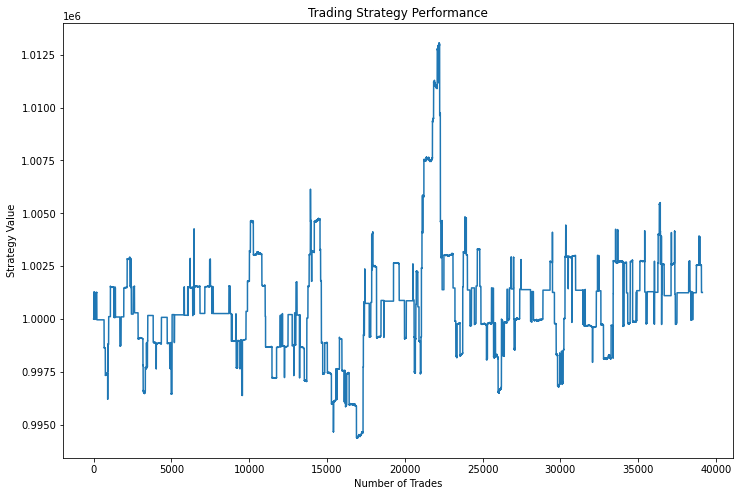

In [15]:
strategy.plot_best_results()

final value best optimized strat

In [16]:
strategy.strategy_value[-1]

1001250.4644411746

In [17]:
len(strategy.strategy_value)

39128

Run and backtest best strat on test data

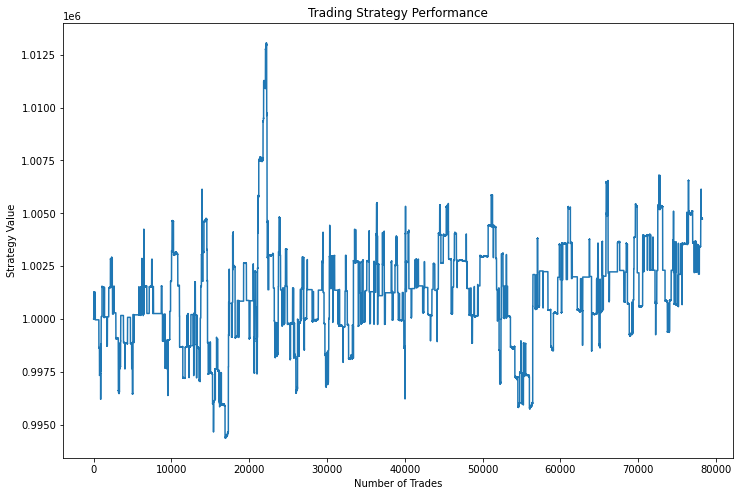

In [18]:
strategy.test()

final value of test

In [19]:
strategy.strategy_value[-1]

1004733.2780115744